# 15. Unet applied to nuclei segmentation

We not try to apply the Unet to a real dataset. It comes again from the Broad collection and consists in images of nuclei imaged by fluorescence microscopy: in other words, nuclei appear as bright blobs in a dark background. The dataset also contains annotations in the form of masks. Those could typically be obtained by manual annotation or correction.

In the first part of this notebook we will show how to create a training dataset out of a larger dataset which is a very common task.

In [1]:
from IPython.display import Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [2]:
from pathlib import Path
import os

import torch
from torch import nn
from torch.functional import F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import jaccard_score

import skimage.io
import matplotlib.pyplot as plt
import numpy as np

The images and labels are located in two separate folders:

In [3]:
imagepath = datapath.joinpath('data/nuclei/BBBC006_v1_images_z_16/')
labelpath = datapath.joinpath('data/nuclei/BBBC006_v1_labels/')

Again we have two channels in this dataset but only use the first one corresponding to files containing ```w1``` in their name. Let's make a list of the images:

In [4]:
image_files = list(imagepath.glob('*w1*.tif'))

Now we load one and plot it:

In [5]:
image = skimage.io.imread(image_files[0])

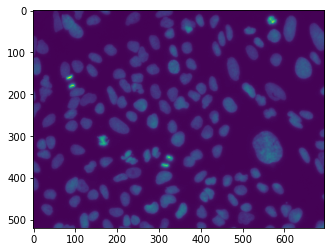

In [6]:
plt.imshow(image);

Out of the 144 images available, we will select a subset of those for training and validation. We create random and *non-overlapping* lists of indices:

In [7]:
np.random.seed(42)
images_training = np.random.choice(np.arange(len(image_files)),10, replace=False)
remaining = np.setdiff1d(np.arange(len(image_files)), images_training)
images_valid = np.random.choice(remaining,2, replace=False)

Now we define that paths where the data should be stored and create the folders if not existing yet:

In [8]:
train_image_path = datapath.joinpath('data/nuclei/train_image')
train_label_path = datapath.joinpath('data/nuclei/train_label')

valid_image_path = datapath.joinpath('data/nuclei/valid_image')
valid_label_path = datapath.joinpath('data/nuclei/valid_label')

if not os.path.isdir(train_image_path):
    os.makedirs(train_image_path)
if not os.path.isdir(train_label_path):
    os.makedirs(train_label_path)
if not os.path.isdir(valid_image_path):
    os.makedirs(valid_image_path)
if not os.path.isdir(valid_label_path):
    os.makedirs(valid_label_path)
                                       

Now we will sequentially load the images as well as the corresponding masks. Those have a name matching the 28 first characters of the image name, so we can simply create the mask name like this by combining the ```labelpath``` with a modified file name:

In [9]:
ind = 0
image = skimage.io.imread(image_files[ind])
im_label_file = labelpath.joinpath(image_files[ind].name[0:28]+'.png')
im_label_file

PosixPath('../data/nuclei/BBBC006_v1_labels/mcf-z-stacks-03212011_a13_s1.png')

Now we can load the labels. Those have separate indices for each nucleus. However here we only want a binary mask, so we set every mask pixel larger than zero to 1:

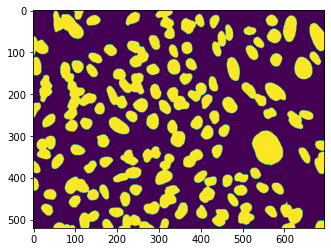

In [10]:
im_label = skimage.io.imread(im_label_file)
im_label[im_label>0] = 1
plt.imshow(im_label);

Finally we crop the images to reasonable sizes. The goal of this is to be able to **mix** crops from different images in a single batch. This helps training as it avoid that the network learns specific features of a given image and instead tries to generalize. To generate the crops we simply use a for loop. The exported file names for images and labels are exported with a same indexing count so that we can later easily match them:

In [11]:
counter = 0
for k in images_training:
    image = skimage.io.imread(image_files[k])
    im_label_file = labelpath.joinpath(image_files[k].name[0:28]+'.png')
    im_label = skimage.io.imread(im_label_file)
    im_label[im_label>0] = 1
    for i in range(image.shape[0]//128):
        for j in range(image.shape[1]//128):

            new_name = train_image_path.joinpath(f'image_{str(counter)}_{str(i)}_{str(j)}.tif')
            newlabelname = train_label_path.joinpath(f'label_{str(counter)}_{str(i)}_{str(j)}.tif')
            subimage = image[i*128:(i+1)*128,j*128:(j+1)*128]
            sublabel = im_label[i*128:(i+1)*128,j*128:(j+1)*128]
            
            skimage.io.imsave(new_name, subimage, check_contrast=False)
            skimage.io.imsave(newlabelname, sublabel, check_contrast=False)
            counter += 1

Now we do the same for the validation set:

In [12]:
for k in images_valid:
    image = skimage.io.imread(image_files[k])
    im_label_file = labelpath.joinpath(image_files[k].name[0:28]+'.png')
    im_label = skimage.io.imread(im_label_file)
    im_label[im_label>0] = 1
    for i in range(image.shape[0]//128):
        for j in range(image.shape[1]//128):

            new_name = valid_image_path.joinpath(f'image_{str(counter)}_{str(i)}_{str(j)}.tif')
            newlabelname = valid_label_path.joinpath(f'label_{str(counter)}_{str(i)}_{str(j)}.tif')
            subimage = image[i*128:(i+1)*128,j*128:(j+1)*128]
            sublabel = im_label[i*128:(i+1)*128,j*128:(j+1)*128]
            
            skimage.io.imsave(new_name, subimage, check_contrast=False)
            skimage.io.imsave(newlabelname, sublabel, check_contrast=False)

## Dataset

We can finally create our standard PyTorch ```Dataset```. Here we will pass lists of image file paths when creating our object. Note that we have to take care of several things. Firs when we import an image it is in 16bit:

In [13]:
image.dtype

dtype('uint16')

The ```ToTensor``` transform does not handle this format so we have first to convert it. We need it as an 8bit integer with values ```[0, 255]```:

In [14]:
im = image.astype(np.float32)
im = 255*im/im.max()
im = im.astype(np.uint8)

On the other hand we need the label image to be a a 64bit integer filled with 0's and 1's, our two categories. However when we use ```ToTensor```, the image is rescaled. So we avoid for the moment that transform and just use ```torch.tensor```:

In [15]:
im_label = skimage.io.imread(list(train_label_path.glob('*.tif'))[0])

In [16]:
label_tensor = torch.tensor(im_label, dtype=torch.int64)

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

class Nuclei(Dataset):
    def __init__(self, image_list, label_list, transform=None):
        super(Nuclei, self).__init__()
        
        self.image_list = image_list
        self.label_list = label_list

        self.transform = transform
        
    def __getitem__(self, index):
        
        x = skimage.io.imread(self.image_list[index]).astype(np.float32)
        # range 0-1
        x = 255*x/x.max()
        x = x.astype(np.uint8)
        y = skimage.io.imread(self.label_list[index])
        y = torch.tensor(y, dtype=torch.int64)
        if self.transform is not None:
            x = self.transform(x)
                
        return x, y

    def __len__(self):

        return len(self.image_list)

Notice that in this approach we do not apply the ```transform``` to the mask. As long as we don't use geometric transforms this is ok, but if we wanted to do it, we would have to make sure that the same transform is applied to image and mask.

For the moment let's find the list of all our images and labels. We simply use ```glob``` and sort the list:

In [18]:
train_images = np.sort(list(Path('/Users/gw18g940/Desktop/Test_data/CAS_imaging/nuclei/train_image/').glob('*.tif')))
train_labels = np.sort(list(Path('/Users/gw18g940/Desktop/Test_data/CAS_imaging/nuclei/train_label/').glob('*.tif')))

valid_images = np.sort(list(Path('/Users/gw18g940/Desktop/Test_data/CAS_imaging/nuclei/valid_image/').glob('*.tif')))
valid_labels = np.sort(list(Path('/Users/gw18g940/Desktop/Test_data/CAS_imaging/nuclei/valid_label/').glob('*.tif')))


Finally we can create our two ```Datasets``` and ```DataLoaders```

In [19]:
train_dataset = Nuclei(image_list=train_images, label_list=train_labels, transform=transform)
valid_dataset = Nuclei(image_list=valid_images, label_list=valid_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10)
valid_loader = DataLoader(valid_dataset, batch_size=10)

Let's check that the output is as expected:

In [20]:
test_im, test_lab = next(iter(train_loader))

In [21]:
test = iter(train_loader)

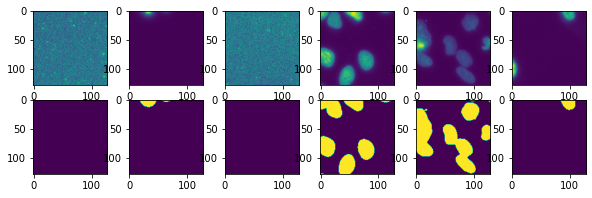

In [22]:
fig, ax = plt.subplots(2,6, figsize=(10,3))
for i in range(6):
    test_im, test_lab = next(test)
    ax[0,i].imshow(test_im[0,0])
    ax[1,i].imshow(test_lab[0]);

## Unet

We copy here the Unet we defined in the previous chapter:

In [23]:
class Unet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate):
        super(Unet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.learning_rate = learning_rate
        
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x2_t = self.transpose_conv3(x3)
        x = torch.cat((x2, x2_t),dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x),dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        #self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        output_proj = output.argmax(dim=1)
        jaccard = jaccard_score(y.view(-1), output_proj.view(-1), average='macro')

        #self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Jaccard/Valid", jaccard, self.current_epoch)

        return jaccard
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        

## Training

Finally we can train our model:

In [24]:
unet = Unet(num_classes=2, learning_rate=1e-3)

In [25]:
logger = TensorBoardLogger("tb_logs", name="unet_nuclei")
trainer = pl.Trainer(max_epochs=30, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:
trainer.fit(unet, train_dataloaders=train_loader, val_dataloaders=valid_loader)


   | Name            | Type             | Params
------------------------------------------------------
0  | conv1           | Conv2d           | 160   
1  | maxpool1        | MaxPool2d        | 0     
2  | conv2           | Conv2d           | 4.6 K 
3  | maxpool2        | MaxPool2d        | 0     
4  | conv3           | Conv2d           | 18.5 K
5  | transpose_conv3 | ConvTranspose2d  | 8.2 K 
6  | conv2_t         | Conv2d           | 18.5 K
7  | transpose_conv2 | ConvTranspose2d  | 2.1 K 
8  | conv1_t         | Conv2d           | 4.6 K 
9  | conv_final      | Conv2d           | 34    
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
56.7 K    Trainable params
0         Non-trainable params
56.7 K    Total params
0.227     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2:  41%|████      | 9/22 [00:17<00:24,  1.92s/it, loss=0.343, v_num=11] 

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

## Check the output

We see that the training worked reasonably well. Let's plot a few examples to try understanding what the remaining problems might be:

In [27]:
val_iter = iter(valid_loader)
test_batch, test_label = next(val_iter)

In [28]:
pred = unet(test_batch)

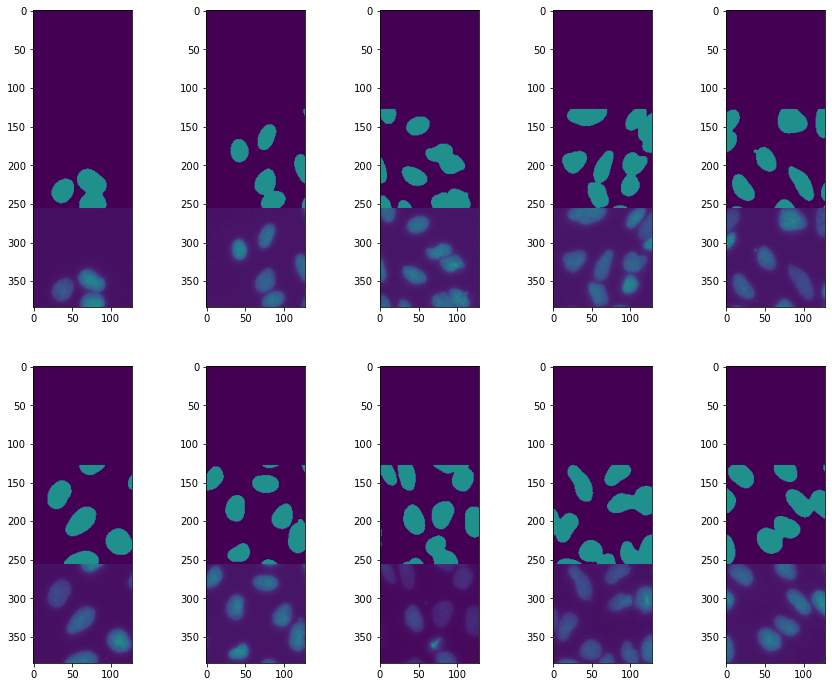

Epoch 2:  41%|████      | 9/22 [00:29<00:43,  3.33s/it, loss=0.343, v_num=11]

In [29]:
fig, ax = plt.subplots(2,5, figsize=(15,12))
ind=0
for row in range(2):
    for col in range(5):
        ax[row, col].imshow(torch.cat((pred[ind].argmax(dim=0),test_label[ind], test_batch[ind,0])),vmin=0,vmax=2)
        ind +=1

## Adding augmentations

The segmentation is reasonable, however its cleat that we are missing some nuclei. One solution might be to *augment* our dataset by playing with image brightness. We don't want the network to only learn that we look for bright objects but rather for certain shapes.

In order to do these brightness transformations, and also to make in the future geometric transforms on both images and masks, we will use here a new package called [albumentations](https://albumentations.ai/).

It works in almost the same way as the torchivision transforms but offers more choice in the modifications. We first *compose* a transformation as previously

In [30]:
import albumentations as A
from albumentations import pytorch

Here we play with brightness and contrast and also with image rotations to illustrate geometric transforms. The last element is the equivalent to the precedent ```ToTensor```. Note that you can use the albumentations package with TF/Keras as well.

Notice also that once again we define one ```transform``` for training and one for validation that doesn't include the augmentation:

In [31]:
transform_A = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomRotate90(),
    pytorch.ToTensorV2()
])

transform_A_valid = A.Compose([
    pytorch.ToTensorV2()
])

We still have to prepare our image so that it can be processed for augmentation. Here we turn it into a float image and normalize it:

In [32]:
image = skimage.io.imread(train_images[6])
im = image.astype(np.float32)
im = im/im.max()

We also load the label and turn it into a 64bit integer, as needed as PyTorch label:

In [33]:
label = skimage.io.imread(train_labels[6]).astype(int)

Finally, we can apply our transformation. Here there's a difference with the torchvision approach: we can pass both an image **and** as mask, and **only the relevant transformations** are applied to the mask. For example the color changes are not applied:

In [34]:
trA = [transform_A(image=im, mask=label) for i in range(10)]

We can see that in plotting the transformed images and masks: masks get rotated but their intensity doesn't change!

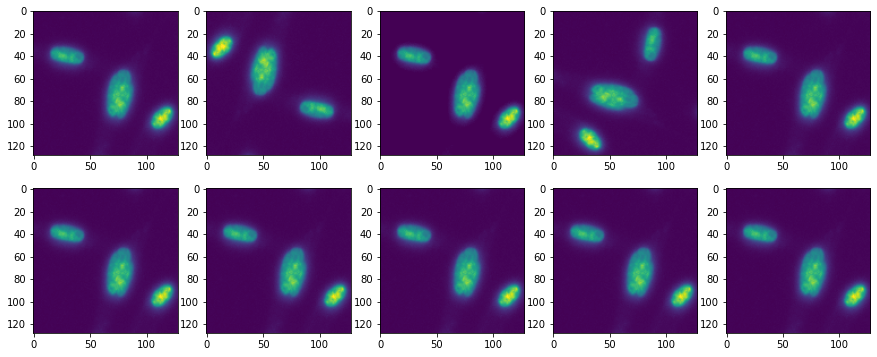

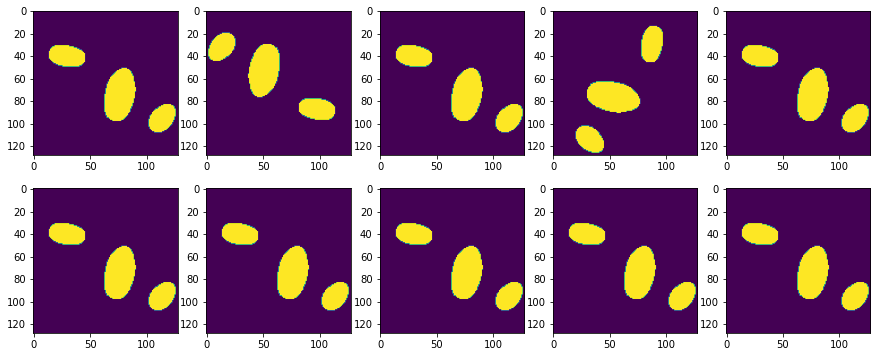

In [35]:
fig, ax = plt.subplots(2,5, figsize=(15,6))
counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(trA[counter]['image'][0])
        counter +=1
        
fig, ax = plt.subplots(2,5, figsize=(15,6))
counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(trA[counter]['mask'])
        counter +=1

Let's slightly rewrite our ```Dataset```:

In [36]:
class NucleiA(Dataset):
    def __init__(self, image_list, label_list, transform=None):
        super(NucleiA, self).__init__()
        
        self.image_list = image_list
        self.label_list = label_list

        self.transform = transform
        
    def __getitem__(self, index):
        
        x = skimage.io.imread(self.image_list[index]).astype(np.float32)
        # range 0-1
        x = x/x.max()
        y = skimage.io.imread(self.label_list[index]).astype(int)
        if self.transform is not None:
            tr = self.transform(image=x, mask=y)
            x = tr['image']
            y = tr['mask']
                
        return x, y

    def __len__(self):

        return len(self.image_list)

In [37]:
train_dataset = NucleiA(image_list=train_images, label_list=train_labels, transform=transform_A)
valid_dataset = NucleiA(image_list=valid_images, label_list=valid_labels, transform=transform_A_valid)
train_loader = DataLoader(train_dataset, batch_size=10)
valid_loader = DataLoader(valid_dataset, batch_size=10)

In [38]:
test = iter(train_loader)

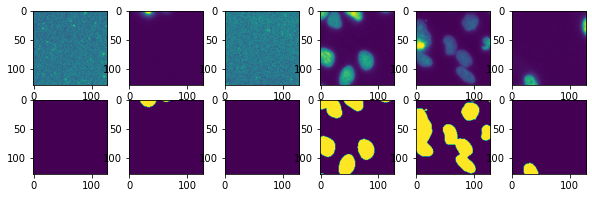

In [39]:
fig, ax = plt.subplots(2,6,figsize=(10,3))
for i in range(6):
    test_im, test_lab = next(test)
    ax[0,i].imshow(test_im[0,0])
    ax[1,i].imshow(test_lab[0]);

Finally we retrain the network:

In [40]:
unet = Unet(num_classes=2, learning_rate=1e-3)
logger = TensorBoardLogger("tb_logs", name="unet_nuclei")
trainer = pl.Trainer(max_epochs=30, logger=logger)
trainer.fit(unet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name            | Type             | Params
------------------------------------------------------
0  | conv1           | Conv2d           | 160   
1  | maxpool1        | MaxPool2d        | 0     
2  | conv2           | Conv2d           | 4.6 K 
3  | maxpool2        | MaxPool2d        | 0     
4  | conv3           | Conv2d           | 18.5 K
5  | transpose_conv3 | ConvTranspose2d  | 8.2 K 
6  | conv2_t         | Conv2d           | 18.5 K
7  | transpose_conv2 | ConvTranspose2d  | 2.1 K 
8  | conv1_t         | Conv2d           | 4.6 K 
9  | conv_final      | Conv2d           | 34    
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
56.7 K    Trainable params
0         Non-trainable params
56.7 K    Total params
0.227     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1:  14%|█▎        | 3/22 [00:04<00:28,  1.53s/it, loss=0.529, v_num=12] 

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Epoch 1:  14%|█▎        | 3/22 [00:13<01:27,  4.61s/it, loss=0.529, v_num=12]

We can visually check the result:

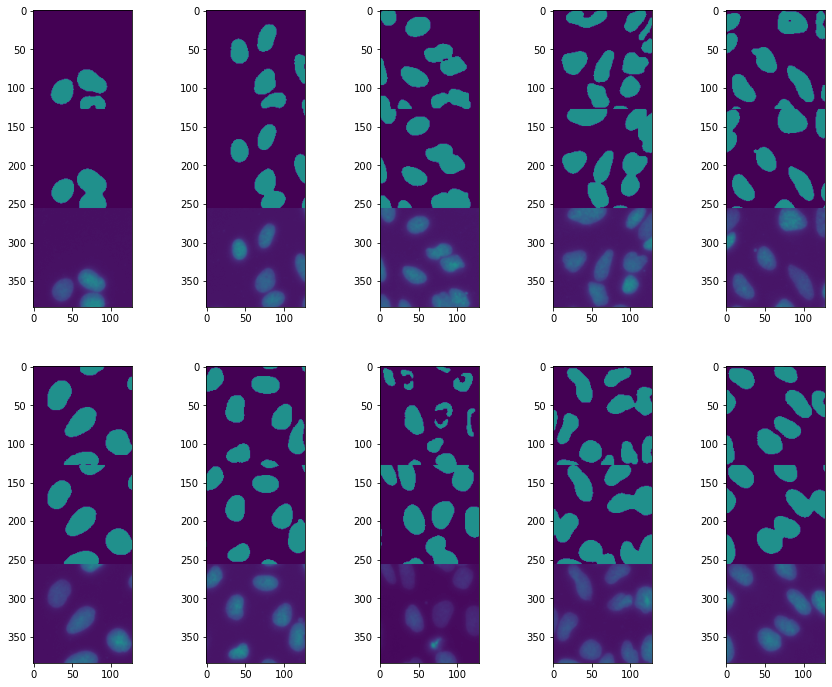

In [67]:
val_iter = iter(valid_loader)
test_batch, test_label = next(val_iter)
pred = unet(test_batch)

fig = plt.figure(figsize=(15,12))
spec = fig.add_gridspec(ncols=5, nrows=2)

ind=0
for row in range(2):
    for col in range(5):
        
        ax = fig.add_subplot(spec[row, col])
        ax.imshow(torch.cat((pred[ind].argmax(dim=0),test_label[ind], test_batch[ind,0])),vmin=0,vmax=2)
        ind +=1

The result has improved, but we still lack some nuclei "centers". What this suggests is that the central regions are sometimes not recognized as being part of a nucleus. This also suggests that the size of the regions captured by downsizing the image is not large enough: filters that pass in the middle of a nucleus sometimes don't "notice" that they are in a nucleus because the border is too far away. To fix this we can try to make our network visit even more coarse-grained sizes by adding a convolution-maxpooling layer.

## Deeper Unet

Here we add one layer of downsizing. We can keep the entire structure and just add a few additional layers a the "center" of the network between encoder and decoder.

In [41]:
class Unet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate):
        super(Unet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.transpose_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, padding=0, stride=2)
        self.conv3_t = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.learning_rate = learning_rate
        
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x = self.maxpool3(x3)
        x4 = F.relu(self.conv4(x))
        x3_t = self.transpose_conv4(x4)
        x = torch.cat((x3, x3_t),dim=1)
        x = F.relu(self.conv3_t(x))
        x2_t = self.transpose_conv3(x)
        x = torch.cat((x2, x2_t),dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x),dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        #self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        output_proj = output.argmax(dim=1)
        jaccard = jaccard_score(y.view(-1), output_proj.view(-1), average='macro')

        #self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Jaccard/Valid", jaccard, self.current_epoch)

        return jaccard
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [42]:
unet = Unet(num_classes=2, learning_rate=1e-3)
logger = TensorBoardLogger("tb_logs", name="unet_nuclei")
trainer = pl.Trainer(max_epochs=30, logger=logger)
trainer.fit(unet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name            | Type             | Params
------------------------------------------------------
0  | conv1           | Conv2d           | 160   
1  | maxpool1        | MaxPool2d        | 0     
2  | conv2           | Conv2d           | 4.6 K 
3  | maxpool2        | MaxPool2d        | 0     
4  | conv3           | Conv2d           | 18.5 K
5  | maxpool3        | MaxPool2d        | 0     
6  | conv4           | Conv2d           | 73.9 K
7  | transpose_conv4 | ConvTranspose2d  | 32.8 K
8  | conv3_t         | Conv2d           | 73.8 K
9  | transpose_conv3 | ConvTranspose2d  | 8.2 K 
10 | conv2_t         | Conv2d           | 18.5 K
11 | transpose_conv2 | ConvTranspose2d  | 2.1 K 
12 | conv1_t         | Conv2d           | 4.6 K 
13 | conv_final      | Conv2d           | 34    
14 | loss            | CrossEntropyLoss | 0     
-------------------------------------------------

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1:  18%|█▊        | 4/22 [00:05<00:26,  1.48s/it, loss=0.526, v_num=13] 

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


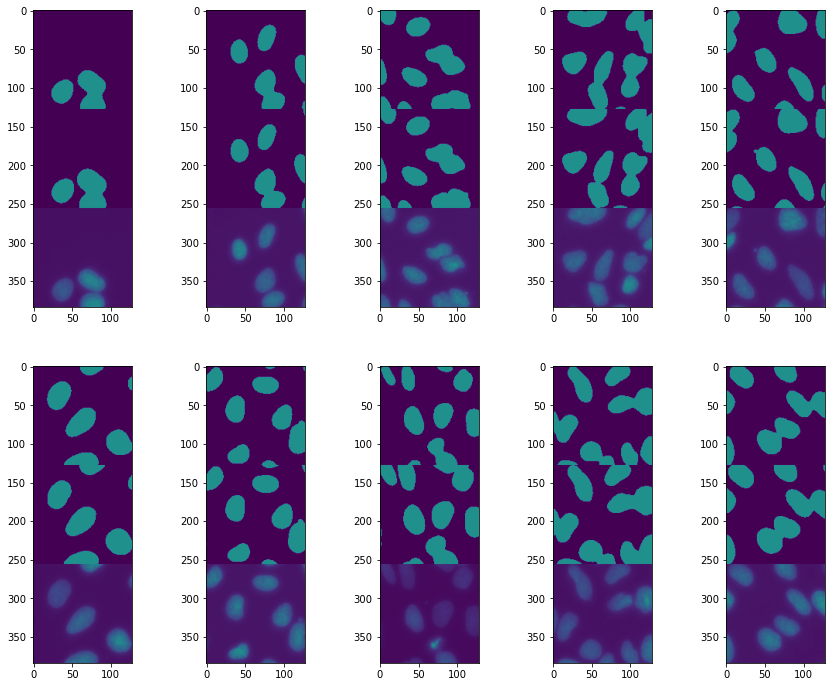

In [70]:
val_iter = iter(valid_loader)
test_batch, test_label = next(val_iter)
pred = unet(test_batch)

fig = plt.figure(figsize=(15,12))
spec = fig.add_gridspec(ncols=5, nrows=2)

ind=0
for row in range(2):
    for col in range(5):
        
        ax = fig.add_subplot(spec[row, col])
        ax.imshow(torch.cat((pred[ind].argmax(dim=0),test_label[ind], test_batch[ind,0])),vmin=0,vmax=2)
        ind +=1

This is a success! All our nuclei are now nicely segmented. This highlights how important it is to tailor a neural net architecture for a given problem.

## Exercise

Our Unet network has become quite complex and difficult to read. However it is very "regular" with repetitive blocks and predictable input/ouptut dimensions.

Try to turn the Unet into a series of sub-blocks which will make the definition more readable and flexible.